In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Enable synchronous CUDA for better error reporting

In [3]:
import pandas as pd
import os
import torch
import numpy as np

In [4]:
import torch.nn as nn
from torchvision.models import resnet50

In [5]:
# Additional imports for TensorBoard, confusion matrix, and visualization
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn.metrics import f1_score

In [6]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA GeForce RTX 3090


In [32]:
csv_path = 'stacked_patches_npy2\stack_mapping.csv'

In [33]:
# Load the new pre-split CSV file
csv_path = 'stacked_patches_npy2/stacked_arrays_split_fixed_stride.csv'
output_dir = './'
output_suffix = '_final.csv'

# CSV einlesen
print("Loading CSV file...")
df = pd.read_csv(csv_path)
print(f"Total samples: {len(df)}")

# Spaltennamen anzeigen zur Überprüfung
print("Columns in CSV:", df.columns.tolist())
print("First few rows:")
print(df.head())

# Label berechnen: class - 3 (um 0-basierte Labels zu erhalten)
df['label'] = df['class']

# Filename für die finale CSV (bleibt wie output_file)
df['filename'] = df['output_file']

print(f"\nClass distribution:")
print(df['class'].value_counts().sort_index())
print(f"\nLabel distribution (after -3):")
print(df['label'].value_counts().sort_index())

# Stratified train/test/val split (70/15/15)
print("\nCreating stratified splits...")

# Erste Aufteilung: 70% train, 30% temp (für test+val)
X = df[['filename', 'class', 'patch_id', 'dates', 'input_files']]
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,  # 30% für test+val
    stratify=y,
    random_state=42
)

# Zweite Aufteilung: 30% temp wird aufgeteilt in 15% test und 15% val
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% von 30% = 15% vom Gesamtdatensatz
    stratify=y_temp,
    random_state=42
)

# DataFrames für jede Aufteilung erstellen
train_df = pd.DataFrame({
    'filename': X_train['filename'],
    'label': y_train
})

test_df = pd.DataFrame({
    'filename': X_test['filename'],
    'label': y_test
})

val_df = pd.DataFrame({
    'filename': X_val['filename'],
    'label': y_val
})

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")

print(f"\nClass distribution per split:")
for split_name, split_df in [('Train', train_df), ('Test', test_df), ('Val', val_df)]:
    print(f"\n{split_name}:")
    class_counts = split_df['label'].value_counts().sort_index()
    for label in sorted(split_df['label'].unique()):
        count = class_counts[label]
        percentage = count / len(split_df) * 100
        print(f"  Class {label}: {count} samples ({percentage:.1f}%)")

# CSV-Dateien speichern
slices = [
    ('train', train_df),
    ('test', test_df),
    ('val', val_df)
]

for split_name, split_df in slices:
    out_path = os.path.join(output_dir, f"{split_name}{output_suffix}")
    split_df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")

print(f"\nSuccessfully created stratified train/test/val splits!")
print(f"All files saved with suffix: {output_suffix}")

Loading CSV file...
Total samples: 3775
Columns in CSV: ['output_file', 'class', 'patch_id', 'dates', 'input_files']
First few rows:
       output_file  class  patch_id  \
0  1000_class7.npy      7      1000   
1  1003_class6.npy      6      1003   
2  1004_class6.npy      6      1004   
3  1005_class6.npy      6      1005   
4  1006_class6.npy      6      1006   

                                               dates  \
0  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
1  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
2  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
3  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
4  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   

                                         input_files  
0  ['patches_npy\\230607_reflectance_ortho\\patch...  
1  ['patches_npy\\230607_reflectance_ortho\\patch...  
2  ['patches_npy\\230607_reflectance_ortho\\patch...  
3  ['patches_npy\\230607_reflectance_ortho\\patch...  
4  ['patches_npy\\23

In [35]:
# 🔍 DEBUG: Check current label distribution and fix range issues
print("=== CURRENT LABEL ANALYSIS ===")
print(f"Original class values: {sorted(df['class'].unique())}")
print(f"Current label values: {sorted(df['label'].unique())}")
print(f"Label range: {df['label'].min()} to {df['label'].max()}")

# Check if labels start from 0 (required for PyTorch)
min_label = df['label'].min()
max_label = df['label'].max()
unique_labels = sorted(df['label'].unique())

print(f"Number of unique labels: {len(unique_labels)}")
print(f"Labels are continuous: {unique_labels == list(range(min_label, max_label + 1))}")

# Fix labels to ensure they start from 0
if min_label != 0:
    print(f"⚠️  WARNING: Labels don't start from 0 (start from {min_label})")
    print("🔧 FIXING: Remapping labels to start from 0...")
    
    # Create mapping from current labels to 0-based labels
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    df['label'] = df['label'].map(label_mapping)
    
    print(f"✅ Labels remapped: {label_mapping}")
    print(f"✅ New label range: {df['label'].min()} to {df['label'].max()}")
    print(f"✅ New unique labels: {sorted(df['label'].unique())}")
    
    # Update train/test/val dataframes
    print("🔄 Updating split dataframes...")
    for split_name, split_df in [('train', train_df), ('test', test_df), ('val', val_df)]:
        # Get original labels from filename mapping
        original_labels = []
        for filename in split_df['filename']:
            original_label = df[df['filename'] == filename]['label'].iloc[0]
            original_labels.append(original_label)
        
        # Update the split dataframe
        split_df['label'] = original_labels
        
        # Save updated CSV
        out_path = os.path.join(output_dir, f"{split_name}{output_suffix}")
        split_df.to_csv(out_path, index=False)
        print(f"✅ Updated and saved: {out_path}")
    
    print("✅ All labels are now properly mapped to start from 0")
else:
    print("✅ Labels already start from 0 - no remapping needed")

print(f"\n=== FINAL LABEL SUMMARY ===")
print(f"Label range: {df['label'].min()} to {df['label'].max()}")
print(f"Number of classes: {df['label'].nunique()}")
print(f"Unique labels: {sorted(df['label'].unique())}")
print("=== END LABEL ANALYSIS ===\n")

=== CURRENT LABEL ANALYSIS ===
Original class values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Current label values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Label range: 0 to 4
Number of unique labels: 5
Labels are continuous: True
✅ Labels already start from 0 - no remapping needed

=== FINAL LABEL SUMMARY ===
Label range: 0 to 4
Number of classes: 5
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
=== END LABEL ANALYSIS ===



### Create Custom Dataset Class

In [18]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
import pandas as pd

class CropDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # CSV-Datei lesen, Spalten: filename und label
        self.image_dir = image_dir
        self.transform = transform  # Transform optional, callable
        
        # Validate and fix labels
        print(f"Original label range: {self.data['label'].min()} to {self.data['label'].max()}")
        
        # Ensure labels are non-negative and properly mapped
        min_label = self.data['label'].min()
        if min_label < 0:
            print(f"Warning: Found negative labels (min: {min_label}). Adjusting...")
            self.data['label'] = self.data['label'] - min_label  # Shift to start from 0
        
        # Calculate number of classes from actual data
        self.num_classes = self.data['label'].nunique()
        max_label = self.data['label'].max()
        
        print(f"Adjusted label range: {self.data['label'].min()} to {max_label}")
        print(f"Number of unique classes: {self.num_classes}")
        print(f"Unique labels: {sorted(self.data['label'].unique())}")
        
        # Ensure labels are continuous and start from 0
        unique_labels = sorted(self.data['label'].unique())
        if unique_labels != list(range(len(unique_labels))):
            print("Warning: Labels are not continuous. Remapping...")
            label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
            self.data['label'] = self.data['label'].map(label_mapping)
            print(f"Remapped labels: {sorted(self.data['label'].unique())}")
        
        # Final validation
        assert self.data['label'].min() >= 0, "Labels must be non-negative"
        assert self.data['label'].max() < self.num_classes, f"Labels must be < {self.num_classes}"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Datei- und Labelnamen aus der CSV lesen
            filename = self.data.iloc[idx]['filename']
            label = self.data.iloc[idx]['label']
            
            # Validate label range to prevent CUDA errors
            if label < 0 or label >= self.num_classes:
                print(f"Warning: Invalid label {label} at index {idx}. Clamping to valid range.")
                label = max(0, min(label, self.num_classes - 1))
            
            label = torch.tensor(label, dtype=torch.long)

            # Lade das .npy-Bild
            path = os.path.join(self.image_dir, filename)
            array = np.load(path)  # Shape: [Bands, H, W]

            # === Handle NaN/Inf values ===
            array = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)

            # Zu Tensor konvertieren
            tensor = torch.tensor(array, dtype=torch.float32)

            # Transformation anwenden, falls definiert
            if self.transform:
                tensor = self.transform(tensor)

            return tensor, label
        except Exception as e:
            print(f"Error loading file {filename} at index {idx}: {e}")
            # Create a dummy tensor with the expected shape (100 channels, 224x224 after transform)
            dummy_tensor = torch.zeros(100, 64, 64, dtype=torch.float32)
            dummy_label = torch.tensor(0, dtype=torch.long)  # Use valid label 0
            return dummy_tensor, dummy_label

### Custom Image Transformation Pipeline


In [19]:
import torch.nn.functional as F

class MultiBandTransform:
    def __init__(self, size=224, normalize=False):
        self.size = size
        self.normalize = normalize

    def __call__(self, x):
        # Resize auf 224x224 (bilineare Interpolation, bandweise)
        x = F.interpolate(x.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False)
        x = x.squeeze(0)

        # Datenaugmentation (Flip & Rotation)
        if random.random() > 0.5:
            x = TF.hflip(x)  # Horizontal Flip
        if random.random() > 0.5:
            x = TF.vflip(x)  # Vertikal Flip
        if random.random() > 0.5:
            x = TF.rotate(x, angle=90)  # 90 Rotation

        # Optional: Normalisierung pro Band
        if self.normalize:
            # Min-Max-Normalisierung auf [0, 1] je Kanal
            min_vals = x.amin(dim=(1, 2), keepdim=True)
            max_vals = x.amax(dim=(1, 2), keepdim=True)
            x = (x - min_vals) / (max_vals - min_vals + 1e-6)

        return x


### Dataloader

In [20]:
from torch.utils.data import DataLoader
import platform

# Pfade
image_dir = 'stacked_patches_npy'  # Korrigierter Pfad ohne führenden /
train_csv = 'train_final.csv'
val_csv = 'val_final.csv'
test_csv = 'test_final.csv'

# Transformationen definieren
train_transform = MultiBandTransform(size=64, normalize=True)
val_transform = MultiBandTransform(size=64, normalize=True)

print("=== CREATING DATASETS WITH LABEL VALIDATION ===")

# Datasets - with verbose label fixing
train_dataset = CropDatasetFromCSV(train_csv, image_dir, transform=train_transform)
print("Train dataset created.")

val_dataset = CropDatasetFromCSV(val_csv, image_dir, transform=val_transform)
print("Validation dataset created.")

test_dataset = CropDatasetFromCSV(test_csv, image_dir, transform=val_transform)
print("Test dataset created.")

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Number of classes (train): {train_dataset.num_classes}")
print(f"Number of classes (val): {val_dataset.num_classes}")
print(f"Number of classes (test): {test_dataset.num_classes}")

# Verify all datasets have same number of classes
assert train_dataset.num_classes == val_dataset.num_classes == test_dataset.num_classes, \
    "All datasets must have the same number of classes"

# Set num_workers=0 for Windows to avoid multiprocessing issues
# On Windows, multiprocessing with DataLoader can cause problems
num_workers = 0 if platform.system() == 'Windows' else 2
print(f"Using num_workers={num_workers} for DataLoader")

# Dataloader with Windows compatibility and no pin_memory to avoid CUDA issues
try:
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    print("DataLoaders created successfully (pin_memory=False to avoid CUDA issues)!")
except Exception as e:
    print(f"Error creating DataLoaders with num_workers={num_workers}, falling back to num_workers=0")
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    print("DataLoaders created with num_workers=0 and pin_memory=False")

print("=== DATASET CREATION COMPLETE ===")

=== CREATING DATASETS WITH LABEL VALIDATION ===
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Train dataset created.
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Validation dataset created.
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Test dataset created.

Dataset sizes:
Train: 2642
Val: 567
Test: 566
Number of classes (train): 7
Number of classes (val): 7
Number of classes (test): 7
Using num_workers=0 for DataLoader
DataLoaders created successfully (pin_memory=False to avoid CUDA issues)!
=== DATASET CREATION COMPLETE ===


### Visualize Images from DataLoader

In [11]:
# Get a batch from the train_loader
batch = next(iter(train_loader))
images, labels = batch
print("Batch shape:", images.shape)
print("Batch values (min, max):", images.min().item(), images.max().item())
print("First image values:", images[0])

Batch shape: torch.Size([16, 70, 64, 64])
Batch values (min, max): 0.0 0.999998927116394
First image values: tensor([[[0.6210, 0.5700, 0.6283,  ..., 0.6502, 0.6362, 0.5946],
         [0.5770, 0.5551, 0.6395,  ..., 0.6546, 0.6402, 0.5929],
         [0.6486, 0.6680, 0.6668,  ..., 0.6870, 0.6169, 0.6146],
         ...,
         [0.6543, 0.6242, 0.6446,  ..., 0.6988, 0.7425, 0.6934],
         [0.6428, 0.6701, 0.6549,  ..., 0.6073, 0.5717, 0.5608],
         [0.5824, 0.6712, 0.7033,  ..., 0.7009, 0.6942, 0.6788]],

        [[0.6115, 0.6004, 0.6182,  ..., 0.6894, 0.6485, 0.6106],
         [0.5956, 0.5947, 0.6817,  ..., 0.6792, 0.6572, 0.5900],
         [0.6630, 0.6878, 0.6762,  ..., 0.7055, 0.6357, 0.6245],
         ...,
         [0.6858, 0.6408, 0.6718,  ..., 0.6868, 0.7243, 0.6776],
         [0.6562, 0.7156, 0.6769,  ..., 0.6266, 0.6040, 0.6005],
         [0.6035, 0.6939, 0.7167,  ..., 0.7047, 0.6756, 0.6938]],

        [[0.6085, 0.5662, 0.5954,  ..., 0.6547, 0.6417, 0.5674],
         [0.57

### Visualize Images Before and After Normalization

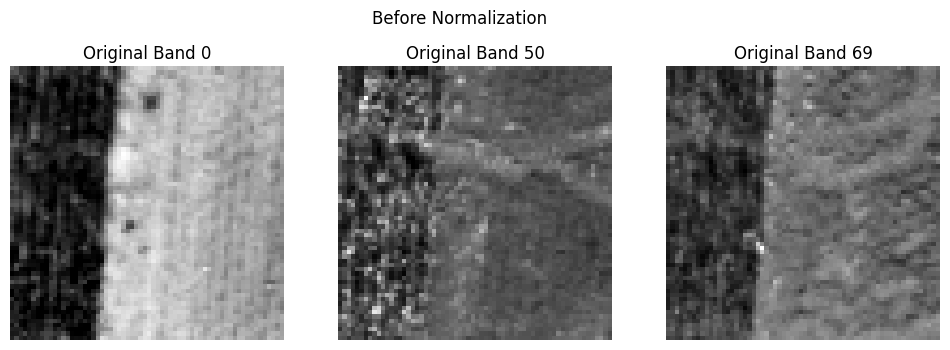

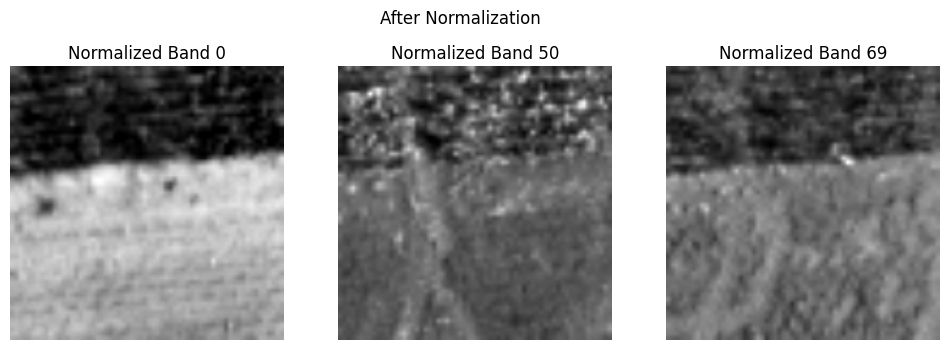

In [12]:
import matplotlib.pyplot as plt

# Load a sample image (as numpy array) from file
sample_filename = train_dataset.data.iloc[0]['filename']
sample_path = os.path.join(train_dataset.image_dir, sample_filename)
sample_array = np.load(sample_path)

# Convert to tensor
sample_tensor = torch.tensor(sample_array, dtype=torch.float32)

# Show original (not normalized)
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 69]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Normalization')
plt.show()

# Apply normalization
transform_norm = MultiBandTransform(size=224, normalize=True)
sample_norm = transform_norm(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 69]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_norm[band], cmap='gray')
    plt.title(f'Normalized Band {band}')
    plt.axis('off')
plt.suptitle('After Normalization')
plt.show()

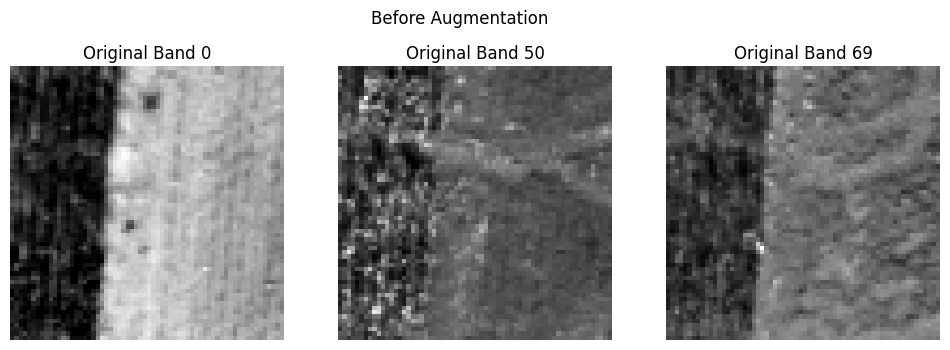

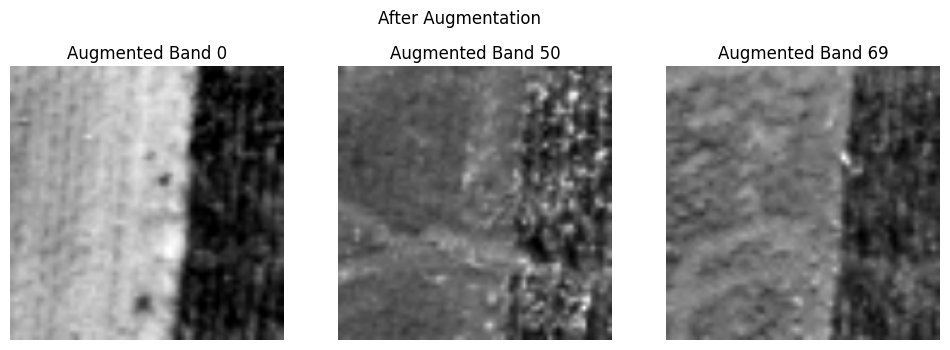

In [44]:
# Use a transform with augmentation (random flip/rotate, no normalization)
transform_aug = MultiBandTransform(size=224, normalize=False)

# Show original
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 69]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Augmentation')
plt.show()

# Apply augmentation
sample_aug = transform_aug(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 69]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_aug[band], cmap='gray')
    plt.title(f'Augmented Band {band}')
    plt.axis('off')
plt.suptitle('After Augmentation')
plt.show()


In [21]:
# Force CPU usage due to CUDA corruption - restart kernel to fix CUDA later
print("🔄 Creating model on CPU due to CUDA context corruption")
print("ℹ️  To fix CUDA: Restart kernel and rerun all cells")

class CustomResNet50(nn.Module):
    def __init__(self, in_channels=70, num_classes=5):  # Updated to 5 classes
        super().__init__()

        # Load standard ResNet-50
        self.model = resnet50(weights=None)  # or pretrained=True if you want pretrained weights

        # Replace the first convolutional layer
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the fully connected (classification) layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of classes from the dataset  
num_classes = train_dataset.num_classes
print(f"Creating model with {num_classes} classes")

model = CustomResNet50(in_channels=70, num_classes=num_classes).to(device)
print(f"✅ Model created successfully on CPU with {num_classes} classes")
print(f"Model output classes: {model.model.fc.out_features}")

print("\n⚠️  IMPORTANT: To use CUDA again:")
print("1. Restart the kernel (Kernel -> Restart)")
print("2. Rerun all cells from the beginning")
print("3. Change device back to 'cuda' in training configuration")


🔄 Creating model on CPU due to CUDA context corruption
ℹ️  To fix CUDA: Restart kernel and rerun all cells
Device: cuda:0
Creating model with 7 classes
✅ Model created successfully on CPU with 7 classes
Model output classes: 7

⚠️  IMPORTANT: To use CUDA again:
1. Restart the kernel (Kernel -> Restart)
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration
✅ Model created successfully on CPU with 7 classes
Model output classes: 7

⚠️  IMPORTANT: To use CUDA again:
1. Restart the kernel (Kernel -> Restart)
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration


### Tests vor dem Training

In [46]:
# Einen Batch laden und Infos anzeigen
batch = next(iter(train_loader))
images, labels = batch

print("Image batch shape:", images.shape)  # [16, 110, 224, 224]
print("Label batch shape:", labels.shape)
print("Beispiel-Label:", labels[0])


Image batch shape: torch.Size([16, 70, 64, 64])
Label batch shape: torch.Size([16])
Beispiel-Label: tensor(2)


In [48]:
# Debug: Check label ranges and values to prevent CUDA errors
print("=== LABEL DEBUGGING ===")

# Check labels in the training dataset
all_train_labels = []
for i in range(min(100, len(train_dataset))):  # Check first 100 samples
    _, label = train_dataset[i]
    all_train_labels.append(label.item())

print(f"Training labels range: {min(all_train_labels)} to {max(all_train_labels)}")
print(f"Unique training labels: {sorted(set(all_train_labels))}")
print(f"Expected range for {train_dataset.num_classes} classes: 0 to {train_dataset.num_classes-1}")

# Check if any labels are out of range
valid_labels = [label for label in all_train_labels if 0 <= label < train_dataset.num_classes]
invalid_labels = [label for label in all_train_labels if label < 0 or label >= train_dataset.num_classes]

print(f"Valid labels count: {len(valid_labels)}")
print(f"Invalid labels: {invalid_labels}")

if invalid_labels:
    print("❌ WARNING: Invalid labels detected! This will cause CUDA errors.")
    print("Labels must be in range [0, num_classes-1]")
else:
    print("✅ All labels are valid.")

# Check validation labels too
all_val_labels = []
for i in range(min(200, len(val_dataset))):  # Check first 50 samples
    _, label = val_dataset[i]
    all_val_labels.append(label.item())

print(f"Validation labels range: {min(all_val_labels)} to {max(all_val_labels)}")
print(f"Unique validation labels: {sorted(set(all_val_labels))}")

print("=== END LABEL DEBUGGING ===\n")

=== LABEL DEBUGGING ===
Training labels range: 0 to 6
Unique training labels: [0, 1, 2, 3, 4, 5, 6]
Expected range for 7 classes: 0 to 6
Valid labels count: 100
Invalid labels: []
✅ All labels are valid.
Validation labels range: 2 to 4
Unique validation labels: [2, 4]
=== END LABEL DEBUGGING ===



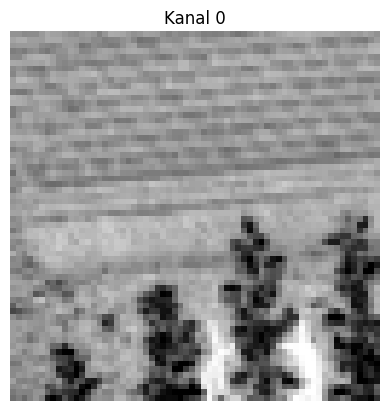

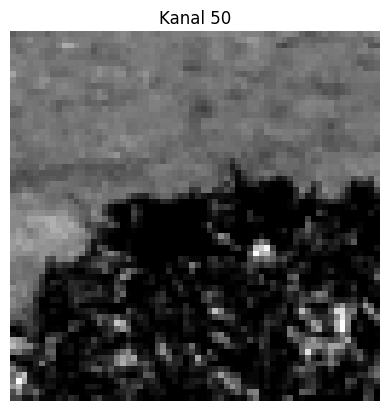

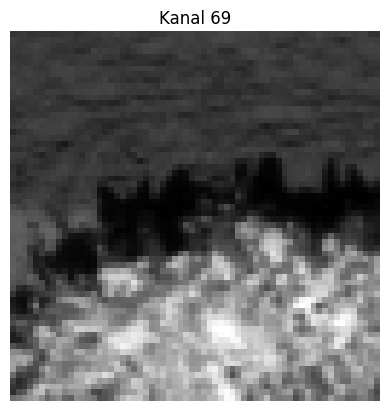

In [49]:
import matplotlib.pyplot as plt

# 1 Bild, 3 Kanäle anzeigen (z. B. Kanal 0, 50, 99)
img = images[0]

for i in [0, 50, 69]: # Changed 100 to 99 to be within bounds
    plt.imshow(img[i].cpu().numpy(), cmap='gray')
    plt.title(f"Kanal {i}")
    plt.axis('off')
    plt.show()

### Training Loop


In [22]:
def training_settings_with_tensorboard(model, epochs, device, optimizer,
                                     criterion, train_dataloader, val_dataloader, weights_name,
                                     log_dir="runs", weights_dir="model_weights", run_name=None, writer=None):
    """
    This function trains a PyTorch model for a specified number of epochs, and evaluates it on a validation set.
    Includes TensorBoard logging for comprehensive monitoring with F1 score.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        epochs (int): The number of epochs to train the model.
        device (str): The device (cpu or cuda) where the model and data are to be loaded.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update the model parameters.
        criterion (torch.nn.modules.loss._Loss): The loss function used to evaluate the model.
        train_dataloader (torch.utils.data.DataLoader): The DataLoader for the training data.
        val_dataloader (torch.utils.data.DataLoader): The DataLoader for the validation data.
        weights_name (str): Base name for saving model weights.
        log_dir (str): Directory for TensorBoard logs.
        run_name (str): Optional name for this run to organize logs better.
        writer (SummaryWriter): Optional external SummaryWriter to use (for shared logging).

    Returns:
        tuple: A tuple containing six lists: train_losses, val_losses, train_accuracy, val_accuracy, train_f1_scores, val_f1_scores
    """
    # Create TensorBoard writer or use provided one
    own_writer = writer is None
    if own_writer:
        # Create our own writer with organized directory structure
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        if run_name:
            # If run_name provided, use it for better organization
            log_path = f'{log_dir}/{run_name}_{timestamp}'
        else:
            # Default naming
            log_path = f'{log_dir}/crop_classification_{timestamp}'
        
        writer = SummaryWriter(log_path)
    else:
        log_path = writer.log_dir
    
    train_losses = []
    val_losses = []
    trn_accuracy = []
    val_accuracy = []
    train_f1_scores = []
    val_f1_scores = []

    # Get number of classes from model
    num_classes = model.model.fc.out_features
    print(f"Model expects {num_classes} classes")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_true_labels = []

        for batch_idx, (images, labels) in enumerate(train_dataloader):
            try:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                # Forward pass
                outputs = model(images)
                
                # Compute loss
                loss = criterion(outputs, labels.long())
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected at epoch {epoch}, batch {batch_idx}")
                    continue
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Update training metrics
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # Store predictions and true labels for F1 score calculation
                train_predictions.extend(predicted.cpu().numpy())
                train_true_labels.extend(labels.cpu().numpy())
                
                # Log batch loss to TensorBoard every 10 batches
                if batch_idx % 10 == 0:
                    tag_prefix = f"{run_name}/" if run_name and not own_writer else ""
                    writer.add_scalar(f'{tag_prefix}Loss/Train_Batch', loss.item(), epoch * len(train_dataloader) + batch_idx)
                    
            except RuntimeError as e:
                print(f"Error in training at epoch {epoch}, batch {batch_idx}: {e}")
                print(f"Labels: {labels}")
                print(f"Images shape: {images.shape}")
                if "assert" in str(e).lower():
                    print("This is likely a label range issue. Check that all labels are in [0, num_classes-1]")
                raise e

        # Compute average training metrics and F1 score
        if train_total > 0:
            train_loss /= len(train_dataloader)
            train_accuracy = 100.0 * train_correct / train_total
            train_losses.append(train_loss)
            trn_accuracy.append(train_accuracy)
            
            # Calculate F1 score for training set
            train_f1 = f1_score(train_true_labels, train_predictions, average='weighted') * 100
            train_f1_scores.append(train_f1)
        else:
            print(f"Warning: No valid training samples in epoch {epoch}")
            continue

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_dataloader):
                try:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Validate labels
                    if torch.any(labels < 0) or torch.any(labels >= num_classes):
                        print(f"Warning: Invalid validation labels in batch {batch_idx}")
                        labels = torch.clamp(labels, 0, num_classes - 1)

                    # Forward pass
                    outputs = model(images)
                    # Compute loss
                    loss = criterion(outputs, labels.long())
                    
                    if torch.isnan(loss):
                        print(f"Warning: NaN validation loss at epoch {epoch}, batch {batch_idx}")
                        continue

                    # Update validation metrics
                    valid_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    valid_total += labels.size(0)
                    valid_correct += (predicted == labels).sum().item()
                    
                    # Store predictions and true labels for F1 score calculation
                    val_predictions.extend(predicted.cpu().numpy())
                    val_true_labels.extend(labels.cpu().numpy())
                    
                except RuntimeError as e:
                    print(f"Error in validation at epoch {epoch}, batch {batch_idx}: {e}")
                    print(f"Labels: {labels}")
                    raise e

        # Compute average validation metrics and F1 score
        if valid_total > 0:
            valid_loss /= len(val_dataloader)
            valid_accuracy = 100.0 * valid_correct / valid_total
            val_losses.append(valid_loss)
            val_accuracy.append(valid_accuracy)
            
            # Calculate F1 score for validation set
            val_f1 = f1_score(val_true_labels, val_predictions, average='weighted') * 100
            val_f1_scores.append(val_f1)
        else:
            print(f"Warning: No valid validation samples in epoch {epoch}")
            continue

        # Log epoch metrics to TensorBoard
        # Use run_name as prefix when using shared writer
        tag_prefix = f"{run_name}/" if run_name and not own_writer else ""
        
        writer.add_scalar(f'{tag_prefix}Loss/Train_Epoch', train_loss, epoch)
        writer.add_scalar(f'{tag_prefix}Loss/Validation_Epoch', valid_loss, epoch)
        writer.add_scalar(f'{tag_prefix}Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar(f'{tag_prefix}Accuracy/Validation', valid_accuracy, epoch)
        writer.add_scalar(f'{tag_prefix}F1_Score/Train', train_f1, epoch)
        writer.add_scalar(f'{tag_prefix}F1_Score/Validation', val_f1, epoch)
        writer.add_scalar(f'{tag_prefix}Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, Valid F1: {val_f1:.2f}%")

        # Save model weights
        torch.save(model.state_dict(), f'{weights_dir}/{weights_name}_epoch_{epoch}.pt')
     
    # Close TensorBoard writer only if we created it
    if own_writer:
        writer.close()
        print(f"TensorBoard logs saved to: {log_path}")
    else:
        print(f"TensorBoard metrics logged to shared writer")
    
    return train_losses, val_losses, trn_accuracy, val_accuracy, train_f1_scores, val_f1_scores

# Single Training

In [54]:
# Training configuration - Updated for current device and classes
model_weights_name = 'best_model_weights_v2'
current_device = next(model.parameters()).device  # Get device from model
print(f"Training will run on: {current_device}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 15  # Reduced for CPU training

print("=== PRE-TRAINING VALIDATION ===")
print(f"Model device: {current_device}")
print(f"Model output classes: {model.model.fc.out_features}")
print(f"Training dataset classes: {train_dataset.num_classes}")
print(f"Validation dataset classes: {val_dataset.num_classes}")

# Verify model and data compatibility
if model.model.fc.out_features == train_dataset.num_classes:
    print("✅ Model and dataset classes match!")
else:
    print(f"❌ ERROR: Model expects {model.model.fc.out_features} classes but dataset has {train_dataset.num_classes}")

print("=== READY TO START TRAINING ===")
print("ℹ️  Training on CPU will be slower than GPU")
print("ℹ️  To use GPU: Restart kernel and rerun all cells")

Training will run on: cuda:0
=== PRE-TRAINING VALIDATION ===
Model device: cuda:0
Model output classes: 5
Training dataset classes: 5
Validation dataset classes: 5
✅ Model and dataset classes match!
=== READY TO START TRAINING ===
ℹ️  Training on CPU will be slower than GPU
ℹ️  To use GPU: Restart kernel and rerun all cells


In [55]:
# Start training with fixed labels
train_losses, val_losses, train_acc, val_acc, train_f1_scores, val_f1_scores = training_settings_with_tensorboard(
    model=model, 
    epochs=epochs, 
    device=current_device,
    optimizer=optimizer, 
    criterion=criterion,
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    weights_name=model_weights_name,
    log_dir="tensorboard_logs"
)

Model expects 5 classes
Epoch [1/15], Train Loss: 1.3561, Train Accuracy: 44.38%, Train F1: 42.63%, Valid Loss: 1.2126, Valid Accuracy: 57.48%, Valid F1: 53.00%
Epoch [2/15], Train Loss: 0.7377, Train Accuracy: 71.88%, Train F1: 70.16%, Valid Loss: 0.9128, Valid Accuracy: 68.17%, Valid F1: 65.03%
Epoch [3/15], Train Loss: 0.6068, Train Accuracy: 78.12%, Train F1: 77.48%, Valid Loss: 0.6573, Valid Accuracy: 78.85%, Valid F1: 76.92%


KeyboardInterrupt: 

### Training Progress Visualization

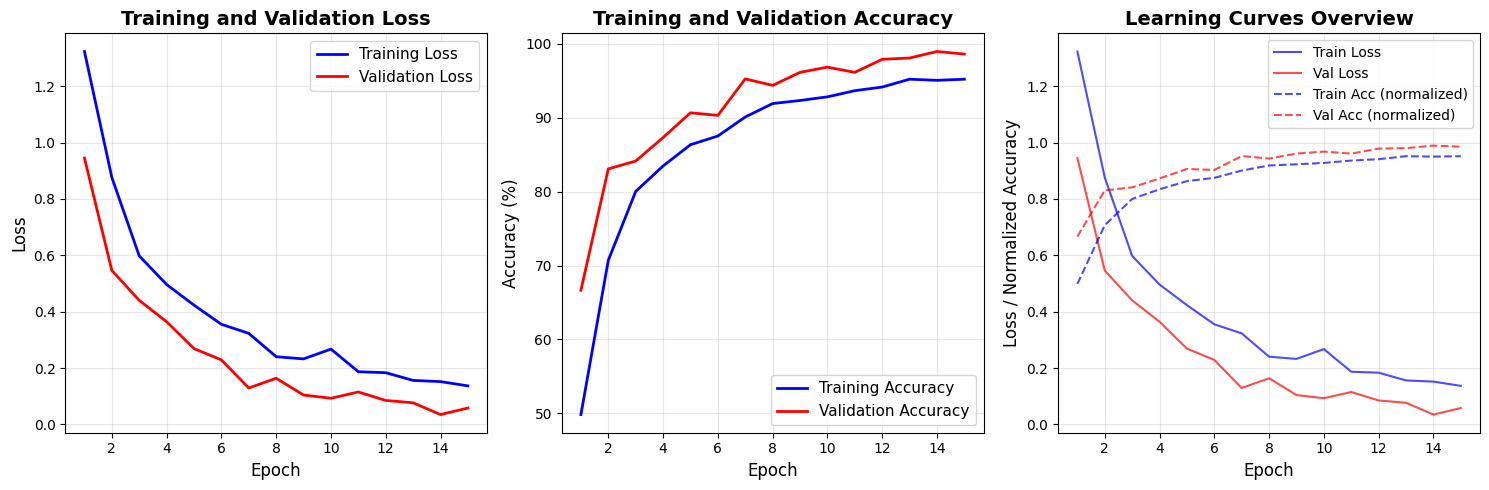


Final Training Results:
Training Loss: 0.1366
Validation Loss: 0.0579
Training Accuracy: 95.19%
Validation Accuracy: 98.59%


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation curves using matplotlib (excluding epoch 0)
plt.figure(figsize=(15, 10))

# Skip epoch 0 by slicing from index 1
train_losses_plot = train_losses[1:] if len(train_losses) > 1 else train_losses
val_losses_plot = val_losses[1:] if len(val_losses) > 1 else val_losses
train_acc_plot = train_acc[1:] if len(train_acc) > 1 else train_acc
val_acc_plot = val_acc[1:] if len(val_acc) > 1 else val_acc
train_f1_plot = train_f1_scores[1:] if len(train_f1_scores) > 1 else train_f1_scores
val_f1_plot = val_f1_scores[1:] if len(val_f1_scores) > 1 else val_f1_scores

# Plot 1: Loss curves
plt.subplot(2, 2, 1)
plt.plot(range(2, len(train_losses) + 1), train_losses_plot, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(2, len(val_losses) + 1), val_losses_plot, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
plt.subplot(2, 2, 2)
plt.plot(range(2, len(train_acc) + 1), train_acc_plot, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(2, len(val_acc) + 1), val_acc_plot, 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 3: F1 Score curves
plt.subplot(2, 2, 3)
plt.plot(range(2, len(train_f1_scores) + 1), train_f1_plot, 'b-', label='Training F1', linewidth=2)
plt.plot(range(2, len(val_f1_scores) + 1), val_f1_plot, 'r-', label='Validation F1', linewidth=2)
plt.title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 Score (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 4: Learning curves comparison
plt.subplot(2, 2, 4)
epochs_range = range(2, len(train_losses) + 1)
plt.plot(epochs_range, train_losses_plot, 'b-', alpha=0.7, label='Train Loss')
plt.plot(epochs_range, val_losses_plot, 'r-', alpha=0.7, label='Val Loss')
# Normalize accuracy and F1 to same scale as loss for comparison
norm_train_acc = [acc/100 for acc in train_acc_plot]
norm_val_acc = [acc/100 for acc in val_acc_plot]
norm_train_f1 = [f1/100 for f1 in train_f1_plot]
norm_val_f1 = [f1/100 for f1 in val_f1_plot]
plt.plot(epochs_range, norm_train_acc, 'b--', alpha=0.7, label='Train Acc (norm)')
plt.plot(epochs_range, norm_val_acc, 'r--', alpha=0.7, label='Val Acc (norm)')
plt.plot(epochs_range, norm_train_f1, 'b:', alpha=0.7, label='Train F1 (norm)')
plt.plot(epochs_range, norm_val_f1, 'r:', alpha=0.7, label='Val F1 (norm)')
plt.title('Learning Curves Overview', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss / Normalized Metrics', fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final training statistics
print(f"\nFinal Training Results:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Validation Accuracy: {val_acc[-1]:.2f}%")
print(f"Training F1 Score: {train_f1_scores[-1]:.2f}%")
print(f"Validation F1 Score: {val_f1_scores[-1]:.2f}%")

### TensorBoard Visualization

To view the TensorBoard logs, run the following command in your terminal:

```bash
tensorboard --logdir=tensorboard_logs
```

Then open your browser and go to `http://localhost:6006` to view:
- Training and validation loss curves
- Accuracy curves
- Learning rate changes
- Real-time training progress

TensorBoard provides interactive plots and allows you to:
- Compare different training runs
- Zoom into specific epochs
- Download plots as images
- Monitor training in real-time

# Hyperparams

In [56]:
# Additional imports for hyperparameter tuning
from itertools import product
import json

In [57]:
def simple_hyperparameter_search(train_loader, val_loader, test_loader, param_grid, 
                                 device='cpu', results_file='hyperparameter_results.json'):
    """
    Perform hyperparameter tuning using simple grid search with existing train/val split.
    
    Args:
        train_loader: Training DataLoader
        val_loader: Validation DataLoader  
        test_loader: Test DataLoader
        param_grid: Dictionary of hyperparameters to search
        device: Device to run on
        results_file: File to save results
    
    Returns:
        best_params: Best hyperparameter combination
        all_results: All experiment results
    """
    
    print("="*80)
    print("HYPERPARAMETER TUNING WITH GRID SEARCH")
    print("="*80)
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))
    
    print(f"Parameter grid: {param_grid}")
    print(f"Total combinations: {len(param_combinations)}")
    print(f"Total training runs: {len(param_combinations)}")
    
    # Create shared TensorBoard writer for all hyperparameter experiments
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    shared_log_dir = f"tensorboard_logs/hyperparameter_search_{timestamp}"
    shared_writer = SummaryWriter(shared_log_dir)
    print(f"Shared TensorBoard logs will be saved to: {shared_log_dir}")
    
    all_results = []
    best_score = -1
    best_params = None
    
    # Test each parameter combination
    for param_idx, param_combo in enumerate(param_combinations):
        # Create parameter dictionary
        current_params = dict(zip(param_names, param_combo))
        print(f"\n{'='*60}")
        print(f"Testing combination {param_idx + 1}/{len(param_combinations)}: {current_params}")
        print(f"{'='*60}")
        
        try:
            # Create model
            model = CustomResNet50().to(device)
            
            # Setup optimizer and criterion based on parameters
            if current_params['optimizer'] == 'adam':
                optimizer = torch.optim.Adam(
                    model.parameters(), 
                    lr=current_params['learning_rate'],
                    weight_decay=current_params.get('weight_decay', 0)
                )
            elif current_params['optimizer'] == 'sgd':
                optimizer = torch.optim.SGD(
                    model.parameters(), 
                    lr=current_params['learning_rate'],
                    momentum=current_params.get('momentum', 0.9),
                    weight_decay=current_params.get('weight_decay', 0)
                )
            
            criterion = nn.CrossEntropyLoss()
            
            # Create new data loaders with current batch size if different
            if current_params['batch_size'] != train_loader.batch_size:
                current_train_loader = DataLoader(
                    train_loader.dataset, 
                    batch_size=current_params['batch_size'], 
                    shuffle=True, 
                    num_workers=0, 
                    pin_memory=False
                )
                current_val_loader = DataLoader(
                    val_loader.dataset, 
                    batch_size=current_params['batch_size'], 
                    shuffle=False, 
                    num_workers=0, 
                    pin_memory=False
                )
            else:
                current_train_loader = train_loader
                current_val_loader = val_loader
            
            # Train model
            # Create descriptive run name for this hyperparameter combination
            run_name = f"hparam_{param_idx}_lr{current_params['learning_rate']}_bs{current_params['batch_size']}_opt{current_params['optimizer'][:3]}_ep{current_params['epochs']}"
            
            train_losses, val_losses, train_acc, val_acc, train_f1, val_f1 = training_settings_with_tensorboard(
                model=model,
                epochs=current_params['epochs'],  # Use epochs from hyperparameter grid
                device=device,
                optimizer=optimizer,
                criterion=criterion,
                train_dataloader=current_train_loader,
                val_dataloader=current_val_loader,
                weights_name=f'hyperparam_search_{param_idx}',
                run_name=run_name,  # Pass descriptive run name
                writer=shared_writer  # Use shared TensorBoard writer
            )
            
            # Calculate performance metrics
            final_train_loss = train_losses[-1] if train_losses else float('inf')
            final_val_loss = val_losses[-1] if val_losses else float('inf')
            final_train_acc = train_acc[-1] if train_acc else 0
            final_val_acc = val_acc[-1] if val_acc else 0
            final_train_f1 = train_f1[-1] if train_f1 else 0
            final_val_f1 = val_f1[-1] if val_f1 else 0
            max_val_acc = max(val_acc) if val_acc else 0
            max_val_f1 = max(val_f1) if val_f1 else 0
            
            # Store results
            result = {
                'params': current_params,
                'final_train_loss': final_train_loss,
                'final_val_loss': final_val_loss,
                'final_train_acc': final_train_acc,
                'final_val_acc': final_val_acc,
                'final_train_f1': final_train_f1,
                'final_val_f1': final_val_f1,
                'max_val_acc': max_val_acc,
                'max_val_f1': max_val_f1,
                'score': max_val_acc,  # Use max validation accuracy as score
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'train_f1': train_f1,
                'val_f1': val_f1
            }
            
            all_results.append(result)
            
            print(f"\nExperiment {param_idx + 1} Results:")
            print(f"  Parameters: {current_params}")
            print(f"  Final Train Accuracy: {final_train_acc:.2f}%")
            print(f"  Final Val Accuracy: {final_val_acc:.2f}%")
            print(f"  Final Train F1: {final_train_f1:.2f}%")
            print(f"  Final Val F1: {final_val_f1:.2f}%")
            print(f"  Max Val Accuracy: {max_val_acc:.2f}%")
            print(f"  Max Val F1: {max_val_f1:.2f}%")
            print(f"  Final Train Loss: {final_train_loss:.4f}")
            print(f"  Final Val Loss: {final_val_loss:.4f}")
            
            # Update best parameters
            if max_val_acc > best_score:
                best_score = max_val_acc
                best_params = current_params.copy()
                print(f"  🎉 NEW BEST PARAMETERS! Score: {best_score:.2f}%")
            
            # Save intermediate results
            with open(results_file, 'w') as f:
                json.dump({
                    'best_params': best_params,
                    'best_score': best_score,
                    'all_results': [
                        {k: v for k, v in r.items() if k not in ['train_losses', 'val_losses', 'train_acc', 'val_acc', 'train_f1', 'val_f1']}
                        for r in all_results  # Save without training curves to keep file size small
                    ]
                }, f, indent=2)
            
        except Exception as e:
            print(f"❌ Error in experiment {param_idx + 1}: {e}")
            error_result = {
                'params': current_params,
                'error': str(e),
                'score': 0
            }
            all_results.append(error_result)
            import traceback
            traceback.print_exc()
    
    # Sort results by score
    all_results.sort(key=lambda x: x.get('score', 0), reverse=True)
    
    print(f"\n{'='*80}")
    print("HYPERPARAMETER TUNING COMPLETE")
    print(f"{'='*80}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {best_score:.2f}%")
    
    print(f"\nTop 3 Parameter Combinations:")
    for i, result in enumerate(all_results[:3]):
        if 'error' not in result:
            print(f"{i+1}. {result['params']} - Score: {result['score']:.2f}%")
        else:
            print(f"{i+1}. {result['params']} - ERROR: {result['error']}")
    
    # Log all hyperparameter experiments to TensorBoard at once
    print(f"\nLogging all hyperparameter experiments to TensorBoard...")
    for i, result in enumerate(all_results):
        if 'error' not in result:
            hparam_dict = {}
            for key, value in result['params'].items():
                if isinstance(value, (int, float, str, bool)):
                    hparam_dict[key] = value
                else:
                    hparam_dict[key] = str(value)
            
            metric_dict = {
                # Final epoch metrics
                'hparam/final_train_loss': result['final_train_loss'],
                'hparam/final_val_loss': result['final_val_loss'],
                'hparam/final_train_accuracy': result['final_train_acc'],
                'hparam/final_val_accuracy': result['final_val_acc'],
                'hparam/final_train_f1': result.get('final_train_f1', 0.0),
                'hparam/final_val_f1': result.get('final_val_f1', 0.0),
                
                # Best performance metrics
                'hparam/max_val_accuracy': result['max_val_acc'],
                'hparam/max_val_f1': result.get('max_val_f1', 0.0),
                'hparam/min_train_loss': min(result.get('train_losses', [float('inf')])),
                'hparam/min_val_loss': min(result.get('val_losses', [float('inf')])),
                'hparam/max_train_accuracy': max(result.get('train_acc', [0.0])),
                'hparam/max_train_f1': max(result.get('train_f1', [0.0])),
                
                # Overall score (for ranking)
                'hparam/score': result['score'],
            }
            
            # Log to shared writer
            shared_writer.add_hparams(hparam_dict, metric_dict)
    
    # Close shared writer
    shared_writer.close()
    print(f"Shared TensorBoard writer closed. All experiments logged to: {shared_log_dir}")
    
    return best_params, all_results

In [58]:
# Define hyperparameter grid for search (simplified for faster execution)
hyperparameter_grid = {
    'learning_rate': [0.0001, 0.0005],  # Reduced options
    'batch_size': [16, 32],            # Batch size options
    'optimizer': ['adam'],
    'weight_decay': [0.001],        # Reduced options
    'epochs': [20, 30, 50],             # Different epoch values to test
}

print("Hyperparameter Grid:")
for param, values in hyperparameter_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in hyperparameter_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

# Configuration
print("\n⚠️  This will train", total_combinations, "models. Each will take a few minutes.")
print("🚀 Starting hyperparameter search...")

Hyperparameter Grid:
  learning_rate: [0.0001, 0.0005]
  batch_size: [16, 32]
  optimizer: ['adam']
  weight_decay: [0.001]
  epochs: [20, 30, 50]

Total combinations to test: 12

⚠️  This will train 12 models. Each will take a few minutes.
🚀 Starting hyperparameter search...


In [59]:
# Execute hyperparameter tuning
try:
    best_params, all_results = simple_hyperparameter_search(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=hyperparameter_grid,
        device="cuda:0",
        results_file='simple_hyperparameter_results_2.json'
    )
    
    print(f"\n🎉 Hyperparameter tuning completed successfully!")
    print(f"Best parameters: {best_params}")
    
except Exception as e:
    print(f"❌ Error during hyperparameter tuning: {e}")
    import traceback
    traceback.print_exc()

HYPERPARAMETER TUNING WITH GRID SEARCH
Parameter grid: {'learning_rate': [0.0001, 0.0005], 'batch_size': [16, 32], 'optimizer': ['adam'], 'weight_decay': [0.001], 'epochs': [20, 30, 50]}
Total combinations: 12
Total training runs: 12
Shared TensorBoard logs will be saved to: tensorboard_logs/hyperparameter_search_20250712_235716

Testing combination 1/12: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.001, 'epochs': 20}
Model expects 5 classes
Epoch [1/20], Train Loss: 1.3030, Train Accuracy: 44.88%, Train F1: 43.70%, Valid Loss: 1.3230, Valid Accuracy: 54.33%, Valid F1: 56.17%
Epoch [2/20], Train Loss: 0.8060, Train Accuracy: 70.21%, Train F1: 70.06%, Valid Loss: 3.2529, Valid Accuracy: 46.68%, Valid F1: 47.94%
Epoch [3/20], Train Loss: 0.5071, Train Accuracy: 81.35%, Train F1: 81.35%, Valid Loss: 0.2786, Valid Accuracy: 89.09%, Valid F1: 89.09%
Epoch [4/20], Train Loss: 0.4587, Train Accuracy: 84.19%, Train F1: 84.19%, Valid Loss: 0.4100, Valid Acc

Traceback (most recent call last):
  File "c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\torch\serialization.py", line 965, in save
    _save(
  File "c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\torch\serialization.py", line 1266, in _save
    zip_file.write_record(name, storage, num_bytes)
RuntimeError: [enforce fail at inline_container.cc:862] . PytorchStreamWriter failed writing file data/306: file write failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\jakob\AppData\Local\Temp\ipykernel_27236\4105898858.py", line 95, in simple_hyperparameter_search
    train_losses, val_losses, train_acc, val_acc, train_f1, val_f1 = training_settings_with_tensorboard(
                                                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jakob\AppData\Local\Temp\ipykernel_27236\63214621.py", line 194, in training_se

Model expects 5 classes
Epoch [1/20], Train Loss: 0.8522, Train Accuracy: 69.15%, Train F1: 68.81%, Valid Loss: 0.2819, Valid Accuracy: 91.34%, Valid F1: 91.36%
Epoch [2/20], Train Loss: 0.3954, Train Accuracy: 88.03%, Train F1: 88.04%, Valid Loss: 0.3409, Valid Accuracy: 88.64%, Valid F1: 88.03%
Epoch [3/20], Train Loss: 0.2838, Train Accuracy: 92.04%, Train F1: 92.02%, Valid Loss: 0.0530, Valid Accuracy: 98.88%, Valid F1: 98.87%
Epoch [4/20], Train Loss: 0.2145, Train Accuracy: 93.65%, Train F1: 93.66%, Valid Loss: 0.0256, Valid Accuracy: 99.44%, Valid F1: 99.44%
Epoch [5/20], Train Loss: 0.1970, Train Accuracy: 94.82%, Train F1: 94.82%, Valid Loss: 0.0240, Valid Accuracy: 99.21%, Valid F1: 99.22%
Epoch [6/20], Train Loss: 0.1472, Train Accuracy: 95.32%, Train F1: 95.32%, Valid Loss: 0.0237, Valid Accuracy: 99.55%, Valid F1: 99.55%
Epoch [7/20], Train Loss: 0.1339, Train Accuracy: 96.16%, Train F1: 96.16%, Valid Loss: 0.0124, Valid Accuracy: 99.78%, Valid F1: 99.78%
Epoch [8/20], Tra

HYPERPARAMETER TUNING RESULTS ANALYSIS

Best Parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.001, 'epochs': 50}
Best Score: 100.00%

All Results (sorted by final_val_f1):
    learning_rate  batch_size optimizer  weight_decay  epochs  final_val_f1
6          0.0005          16      adam         0.001      30    100.000000
9          0.0005          32      adam         0.001      30     99.775573
7          0.0005          16      adam         0.001      50     99.775008
8          0.0005          32      adam         0.001      20     99.438654
10         0.0005          32      adam         0.001      50     99.436299
1          0.0001          16      adam         0.001      30     99.213635
5          0.0005          16      adam         0.001      20     99.212536
4          0.0001          32      adam         0.001      30     98.988488
3          0.0001          32      adam         0.001      20     98.430193
0          0.0001     

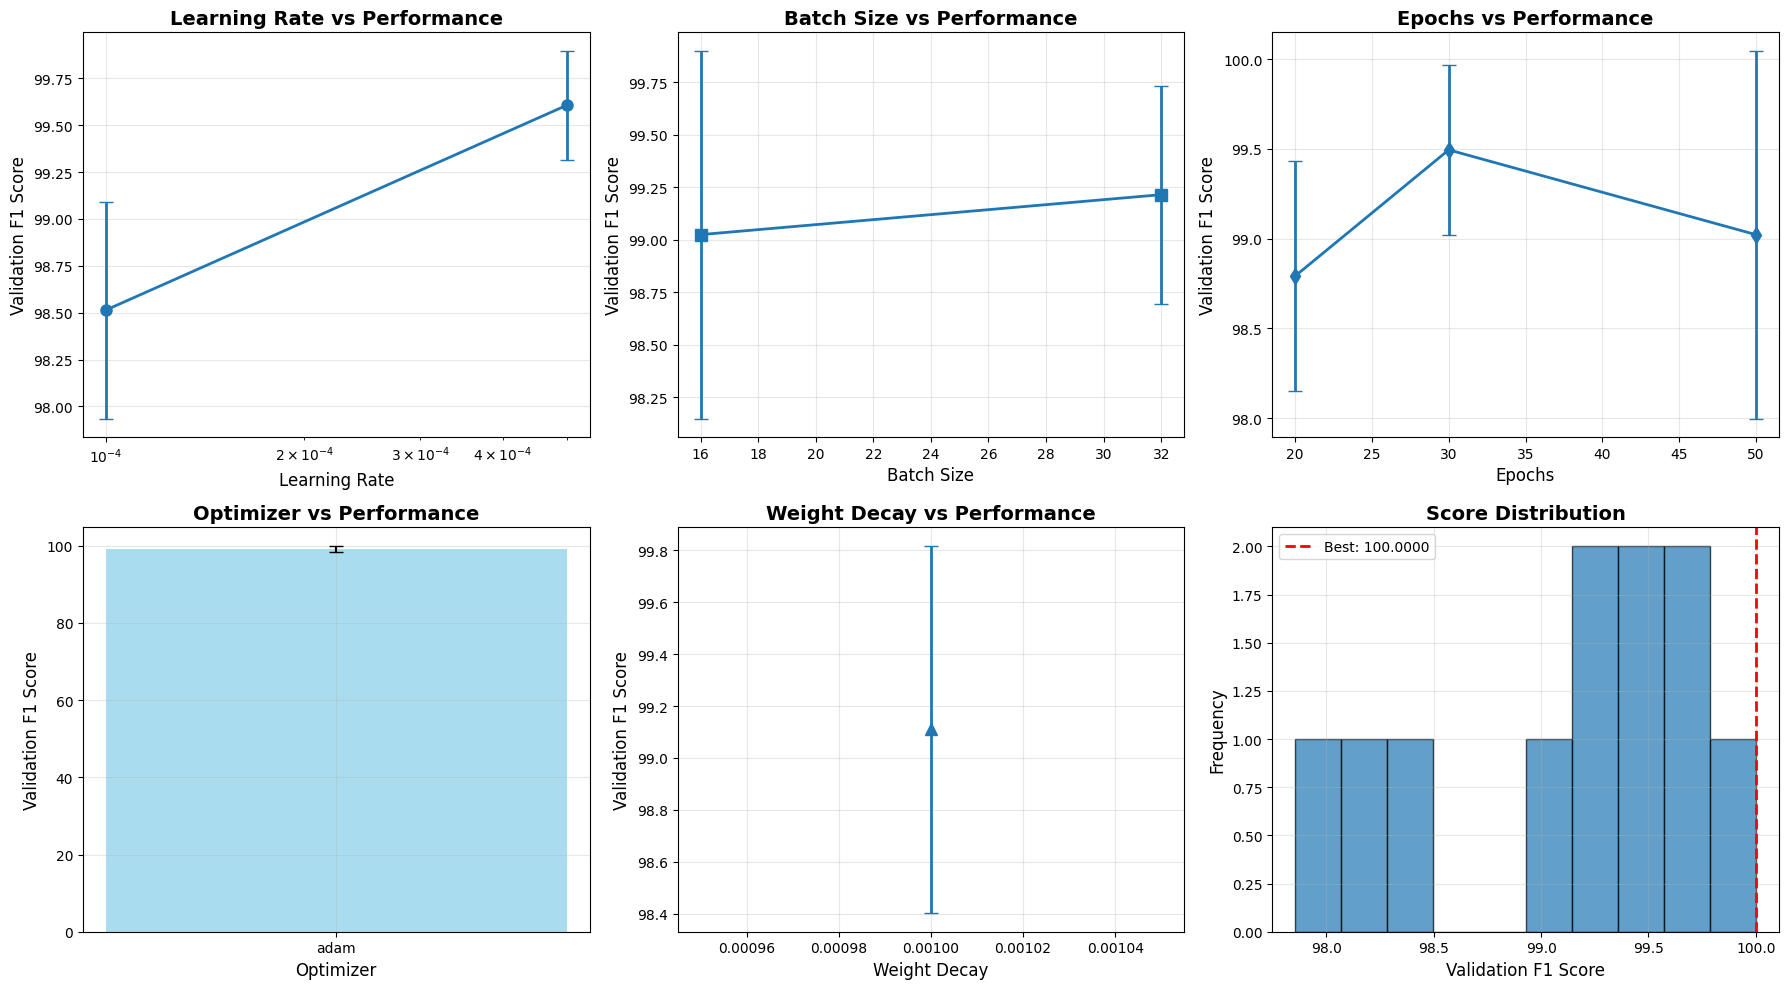


Detailed Performance Comparison:
 learning_rate  batch_size optimizer  weight_decay  epochs  final_train_acc  final_val_acc  max_val_acc    score  final_train_f1  final_val_f1  max_val_f1
        0.0005          16      adam         0.001      30          97.7728       100.0000     100.0000 100.0000         97.7718      100.0000    100.0000
        0.0005          32      adam         0.001      30          98.6080        99.7750     100.0000 100.0000         98.6059       99.7756    100.0000
        0.0005          16      adam         0.001      50          98.6637        99.7750     100.0000 100.0000         98.6630       99.7750    100.0000
        0.0005          32      adam         0.001      20          98.0512        99.4376     100.0000 100.0000         98.0498       99.4387    100.0000
        0.0005          32      adam         0.001      50          99.1091        99.4376     100.0000 100.0000         99.1098       99.4363    100.0000
        0.0001          16      adam

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Analyze and visualize hyperparameter tuning results
def analyze_simple_hyperparameter_results(results_file='simple_hyperparameter_results_2.json'):
    """Load and analyze simple hyperparameter tuning results"""
    
    try:
        with open(results_file, 'r') as f:
            data = json.load(f)
        
        best_params = data['best_params']
        best_score = data['best_score']
        all_results = data['all_results']
        
        print("="*80)
        print("HYPERPARAMETER TUNING RESULTS ANALYSIS")
        print("="*80)
        
        print(f"\nBest Parameters: {best_params}")
        print(f"Best Score: {best_score:.2f}%")
        
        # Filter out error results
        valid_results = [r for r in all_results if 'error' not in r]
        
        if not valid_results:
            print("No valid results found!")
            return None, None
        
        # Create results dataframe for analysis
        results_df = []
        for result in valid_results:
            row = result['params'].copy()
            row['final_val_acc'] = result['final_val_acc']
            row['max_val_acc'] = result['max_val_acc']
            row['final_train_acc'] = result['final_train_acc']
            row['final_val_loss'] = result['final_val_loss']
            row['score'] = result['score']
            # Add F1 scores if available
            if 'final_val_f1' in result:
                row['final_val_f1'] = result['final_val_f1']
                row['final_train_f1'] = result['final_train_f1']
                row['max_val_f1'] = result['max_val_f1']
            results_df.append(row)
        
        results_df = pd.DataFrame(results_df)
        
        # Use final_val_f1 if available, otherwise fallback to score
        performance_metric = 'final_val_f1' if 'final_val_f1' in results_df.columns else 'score'
        performance_label = 'Validation F1 Score' if performance_metric == 'final_val_f1' else 'Validation Accuracy (%)'
        
        print(f"\nAll Results (sorted by {performance_metric}):")
        print(results_df.sort_values(performance_metric, ascending=False)[['learning_rate', 'batch_size', 'optimizer', 'weight_decay', 'epochs', performance_metric]])
        
        # Visualize results
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Changed to 2x3 for epochs plot
        
        # Learning rate vs performance
        lr_performance = results_df.groupby('learning_rate')[performance_metric].agg(['mean', 'std']).reset_index()
        lr_performance['std'] = lr_performance['std'].fillna(0)  # Handle single values
        axes[0,0].errorbar(lr_performance['learning_rate'], lr_performance['mean'], 
                          yerr=lr_performance['std'], marker='o', capsize=5, linewidth=2, markersize=8)
        axes[0,0].set_xscale('log')
        axes[0,0].set_xlabel('Learning Rate', fontsize=12)
        axes[0,0].set_ylabel(performance_label, fontsize=12)
        axes[0,0].set_title('Learning Rate vs Performance', fontsize=14, fontweight='bold')
        axes[0,0].grid(True, alpha=0.3)
        
        # Batch size vs performance
        batch_performance = results_df.groupby('batch_size')[performance_metric].agg(['mean', 'std']).reset_index()
        batch_performance['std'] = batch_performance['std'].fillna(0)
        axes[0,1].errorbar(batch_performance['batch_size'], batch_performance['mean'], 
                          yerr=batch_performance['std'], marker='s', capsize=5, linewidth=2, markersize=8)
        axes[0,1].set_xlabel('Batch Size', fontsize=12)
        axes[0,1].set_ylabel(performance_label, fontsize=12)
        axes[0,1].set_title('Batch Size vs Performance', fontsize=14, fontweight='bold')
        axes[0,1].grid(True, alpha=0.3)
        
        # Epochs vs performance
        epochs_performance = results_df.groupby('epochs')[performance_metric].agg(['mean', 'std']).reset_index()
        epochs_performance['std'] = epochs_performance['std'].fillna(0)
        axes[0,2].errorbar(epochs_performance['epochs'], epochs_performance['mean'], 
                          yerr=epochs_performance['std'], marker='d', capsize=5, linewidth=2, markersize=8)
        axes[0,2].set_xlabel('Epochs', fontsize=12)
        axes[0,2].set_ylabel(performance_label, fontsize=12)
        axes[0,2].set_title('Epochs vs Performance', fontsize=14, fontweight='bold')
        axes[0,2].grid(True, alpha=0.3)
        
        # Optimizer vs performance
        opt_performance = results_df.groupby('optimizer')[performance_metric].agg(['mean', 'std']).reset_index()
        opt_performance['std'] = opt_performance['std'].fillna(0)
        bars = axes[1,0].bar(opt_performance['optimizer'], opt_performance['mean'], 
                            yerr=opt_performance['std'], capsize=5, alpha=0.7, 
                            color=['skyblue', 'lightcoral'])
        axes[1,0].set_xlabel('Optimizer', fontsize=12)
        axes[1,0].set_ylabel(performance_label, fontsize=12)
        axes[1,0].set_title('Optimizer vs Performance', fontsize=14, fontweight='bold')
        axes[1,0].grid(True, alpha=0.3)
        
        # Weight decay vs performance
        wd_performance = results_df.groupby('weight_decay')[performance_metric].agg(['mean', 'std']).reset_index()
        wd_performance['std'] = wd_performance['std'].fillna(0)
        axes[1,1].errorbar(wd_performance['weight_decay'], wd_performance['mean'], 
                          yerr=wd_performance['std'], marker='^', capsize=5, linewidth=2, markersize=8)
        axes[1,1].set_xlabel('Weight Decay', fontsize=12)
        axes[1,1].set_ylabel(performance_label, fontsize=12)
        axes[1,1].set_title('Weight Decay vs Performance', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3)
        
        # Score distribution
        axes[1,2].hist(results_df[performance_metric], bins=min(10, len(results_df)), alpha=0.7, edgecolor='black')
        axes[1,2].axvline(results_df[performance_metric].max(), color='red', linestyle='--', linewidth=2, 
                         label=f'Best: {results_df[performance_metric].max():.4f}')
        axes[1,2].set_xlabel(performance_label, fontsize=12)
        axes[1,2].set_ylabel('Frequency', fontsize=12)
        axes[1,2].set_title('Score Distribution', fontsize=14, fontweight='bold')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Show performance comparison table
        print(f"\nDetailed Performance Comparison:")
        
        # Base columns
        comparison_columns = ['learning_rate', 'batch_size', 'optimizer', 'weight_decay', 'epochs',
                             'final_train_acc', 'final_val_acc', 'max_val_acc', 'score']
        
        # Add F1 columns if available
        if 'final_val_f1' in results_df.columns:
            comparison_columns.extend(['final_train_f1', 'final_val_f1', 'max_val_f1'])
        
        comparison_df = results_df[comparison_columns].round(4)
        comparison_df = comparison_df.sort_values(performance_metric, ascending=False)
        print(comparison_df.to_string(index=False))
        
        return results_df, best_params
        
    except FileNotFoundError:
        print(f"Results file {results_file} not found. Run hyperparameter tuning first.")
        return None, None
    except Exception as e:
        print(f"Error analyzing results: {e}")
        return None, None

# Analyze results (will show message if tuning hasn't been run yet)
results_df, best_hyperparams = analyze_simple_hyperparameter_results()

# Evaluation

In [23]:
def evaluate_model_on_test(model, test_dataloader, device, class_names=None):
    """
    Evaluate the trained model on test data and generate predictions for confusion matrix.
    
    Args:
        model: Trained PyTorch model
        test_dataloader: DataLoader for test data
        device: Device to run evaluation on
        class_names: List of class names for labeling (optional)
    
    Returns:
        tuple: (true_labels, predictions, test_accuracy, test_loss)
    """
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100.0 * correct / total
    average_loss = total_loss / len(test_dataloader)
    
    print(f"Test Results:")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {average_loss:.4f}")
    print(f"Total Test Samples: {total}")
    print(f"Correct Predictions: {correct}")
    
    return all_labels, all_predictions, test_accuracy, average_loss

In [25]:
# Train final model with best hyperparameters
def train_final_model_with_best_params(best_params, train_loader, val_loader, test_loader,
                                     device, epochs=15, save_name='best_hyperparams_model'):
    """Train final model using the best hyperparameters found"""
    
    print("="*80)
    print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
    print("="*80)
    print(f"Best parameters: {best_params}")
    
    # Get number of classes from train_loader
    num_classes = 5
    
    # Create data loaders with best batch size
    if best_params['batch_size'] != train_loader.batch_size:
        final_train_loader = DataLoader(
            train_loader.dataset, 
            batch_size=best_params['batch_size'], 
            shuffle=True, 
            num_workers=0, 
            pin_memory=False
        )
        final_val_loader = DataLoader(
            val_loader.dataset, 
            batch_size=best_params['batch_size'], 
            shuffle=False, 
            num_workers=0, 
            pin_memory=False
        )
        final_test_loader = DataLoader(
            test_loader.dataset, 
            batch_size=best_params['batch_size'], 
            shuffle=False, 
            num_workers=0, 
            pin_memory=False
        )
    else:
        final_train_loader = train_loader
        final_val_loader = val_loader
        final_test_loader = test_loader
    
    # Create model
    final_model = CustomResNet50(
        in_channels=70, 
        num_classes=num_classes
    ).to(device)
    
    # Setup optimizer with best parameters
    if best_params['optimizer'] == 'adam':
        final_optimizer = torch.optim.Adam(
            final_model.parameters(),
            lr=best_params['learning_rate'],
            weight_decay=best_params.get('weight_decay', 0)
        )
    elif best_params['optimizer'] == 'sgd':
        final_optimizer = torch.optim.SGD(
            final_model.parameters(),
            lr=best_params['learning_rate'],
            momentum=best_params.get('momentum', 0.9),
            weight_decay=best_params.get('weight_decay', 0)
        )
    
    final_criterion = nn.CrossEntropyLoss()
    
    # Use epochs from best parameters, with option to override
    best_epochs = best_params.get('epochs', epochs)
    print(f"Training final model for {best_epochs} epochs (from best hyperparameters)...")
    
    # Train final model
    # Create descriptive run name for final model
    final_run_name = f"final_model_lr{best_params['learning_rate']}_bs{best_params['batch_size']}_opt{best_params['optimizer']}_ep{best_epochs}"
    
    final_train_losses, final_val_losses, final_train_acc, final_val_acc, final_train_f1, final_val_f1 = training_settings_with_tensorboard(
        model=final_model,
        epochs=best_epochs,  # Use epochs from best parameters
        device=device,
        optimizer=final_optimizer,
        criterion=final_criterion,
        train_dataloader=final_train_loader,
        val_dataloader=final_val_loader,
        weights_name=save_name,
        log_dir="tensorboard_logs",
        run_name=final_run_name  # Pass descriptive run name
    )
    
    # Evaluate on test set
    print("\nEvaluating final model on test set...")
    final_true_labels, final_predictions, final_test_accuracy, final_test_loss = evaluate_model_on_test(
        final_model, final_test_loader, device
    )
    
    # Save final results
    final_results = {
        'best_hyperparameters': best_params,
        'final_train_losses': final_train_losses,
        'final_val_losses': final_val_losses,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'final_train_f1': final_train_f1,
        'final_val_f1': final_val_f1,
        'test_accuracy': final_test_accuracy,
        'test_loss': final_test_loss,
        'max_val_accuracy': max(final_val_acc) if final_val_acc else 0,
        'max_val_f1': max(final_val_f1) if final_val_f1 else 0
    }
    
    with open('final_model_best_params_results.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    
    print(f"\n🎉 FINAL MODEL TRAINING COMPLETE!")
    print(f"Best validation accuracy: {max(final_val_acc) if final_val_acc else 0:.2f}%")
    print(f"Best validation F1: {max(final_val_f1) if final_val_f1 else 0:.2f}%")
    print(f"Final test accuracy: {final_test_accuracy:.2f}%")
    print(f"Results saved to: final_model_best_params_results.json")
    
    return final_model, final_results, final_true_labels, final_predictions

# Train final model if best hyperparameters are available
if best_hyperparams is not None:
    print("Training final model with best hyperparameters...")
    final_model, final_results, final_true_labels, final_predictions = train_final_model_with_best_params(
        best_params=best_hyperparams,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=15,
        save_name='final_best_hyperparams_model'
    )
else:
    print("⚠️  No best hyperparameters available. Run hyperparameter tuning first.")

Training final model with best hyperparameters...
TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Best parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.001, 'epochs': 50}
Training final model for 50 epochs (from best hyperparameters)...
Model expects 5 classes
Training final model for 50 epochs (from best hyperparameters)...
Model expects 5 classes
Epoch [1/50], Train Loss: 1.3320, Train Accuracy: 41.82%, Train F1: 39.89%, Valid Loss: 1.5801, Valid Accuracy: 47.36%, Valid F1: 42.04%
Epoch [1/50], Train Loss: 1.3320, Train Accuracy: 41.82%, Train F1: 39.89%, Valid Loss: 1.5801, Valid Accuracy: 47.36%, Valid F1: 42.04%
Epoch [2/50], Train Loss: 0.7912, Train Accuracy: 71.16%, Train F1: 69.97%, Valid Loss: 1.0601, Valid Accuracy: 66.93%, Valid F1: 63.97%
Epoch [2/50], Train Loss: 0.7912, Train Accuracy: 71.16%, Train F1: 69.97%, Valid Loss: 1.0601, Valid Accuracy: 66.93%, Valid F1: 63.97%
Epoch [3/50], Train Loss: 0.6202, Train Accuracy: 77.67%

In [26]:
# Evaluate model on test set
true_labels, predictions, test_accuracy, test_loss = evaluate_model_on_test(
    final_model, test_loader, device
)

Test Results:
Test Accuracy: 99.44%
Test Loss: 0.0272
Total Test Samples: 892
Correct Predictions: 887


Total correct predictions: 887
Total incorrect predictions: 5
Showing 4 good predictions and 4 bad predictions


C:\Users\jakob\AppData\Local\Temp\ipykernel_13152\955443097.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jakob\AppData\Local\Temp\ipykernel_13152\955443097.py:91: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas

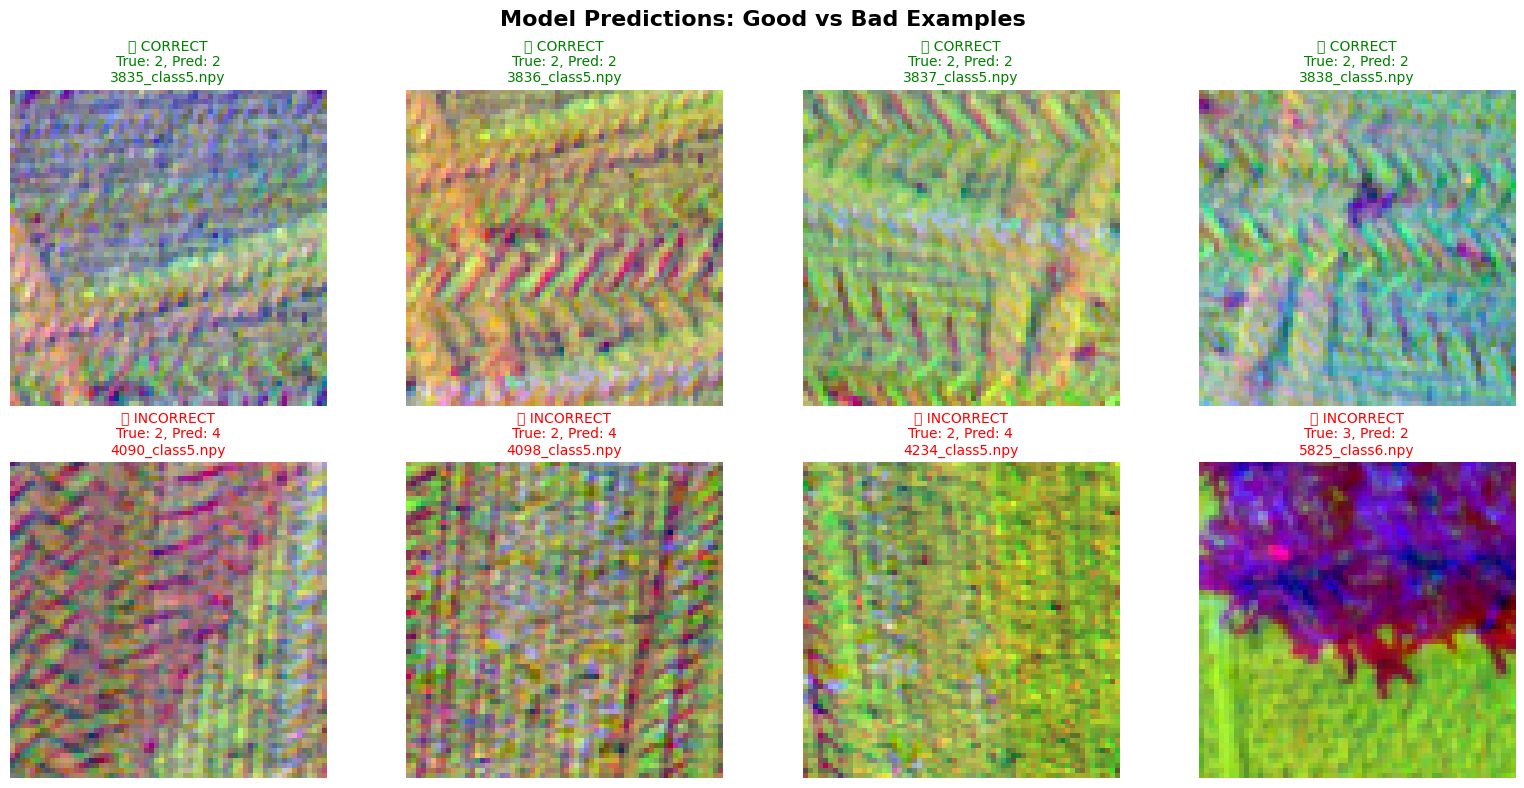


DETAILED ANALYSIS OF EXAMPLES

🟢 CORRECT PREDICTIONS:
  1. File: 4799_class3.npy
     True Label: 2 | Predicted: 2
  2. File: 1714_class5.npy
     True Label: 4 | Predicted: 4
  3. File: 4009_class7.npy
     True Label: 6 | Predicted: 6
  4. File: 2451_class6.npy
     True Label: 5 | Predicted: 5

🔴 INCORRECT PREDICTIONS:
  1. File: 4090_class5.npy
     True Label: 2 | Predicted: 4 (ERROR)
  2. File: 4098_class5.npy
     True Label: 2 | Predicted: 4 (ERROR)
  3. File: 4234_class5.npy
     True Label: 2 | Predicted: 4 (ERROR)
  4. File: 5825_class6.npy
     True Label: 3 | Predicted: 2 (ERROR)

📊 SUMMARY:
Overall Test Accuracy: 99.44%
Correct Predictions: 887/892
Incorrect Predictions: 5/892


In [27]:
import numpy as np

import matplotlib.pyplot as plt

# Get some examples of good and bad predictions
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

print(f"Total correct predictions: {len(correct_indices)}")
print(f"Total incorrect predictions: {len(incorrect_indices)}")

# Select 4 good and 4 bad predictions
good_examples = correct_indices[:4] if len(correct_indices) >= 4 else correct_indices
bad_examples = incorrect_indices[:4] if len(incorrect_indices) >= 4 else incorrect_indices

print(f"Showing {len(good_examples)} good predictions and {len(bad_examples)} bad predictions")

# Function to load and display an image
def show_prediction_example(idx, is_correct=True):
    # Get the filename from test dataset
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    
    # Load the image
    image_path = os.path.join(test_dataset.image_dir, filename)
    image_array = np.load(image_path)
    
    # Apply the same transform as used during testing
    image_tensor = torch.tensor(image_array, dtype=torch.float32)
    transformed_image = val_transform(image_tensor)
    
    return transformed_image, true_label, pred_label, filename

# Create the visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show good predictions
for i, idx in enumerate(good_examples):
    image, true_label, pred_label, filename = show_prediction_example(idx, True)
    
    # Show 3 different bands
    ax = axes[0, i]
    # Create RGB-like visualization using 3 different bands
    if image.shape[0] >= 3:
        rgb_image = np.stack([
            image[0].numpy(),  # Red channel
            image[image.shape[0]//2].numpy(),  # Green channel  
            image[-1].numpy()  # Blue channel
        ], axis=-1)
        # Normalize for display
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax.imshow(rgb_image)
    else:
        ax.imshow(image[0].numpy(), cmap='gray')
    
    ax.set_title(f'✅ CORRECT\nTrue: {true_label}, Pred: {pred_label}\n{filename}', 
                 fontsize=10, color='green')
    ax.axis('off')

# Show bad predictions
for i, idx in enumerate(bad_examples):
    image, true_label, pred_label, filename = show_prediction_example(idx, False)
    
    # Show 3 different bands
    ax = axes[1, i]
    # Create RGB-like visualization using 3 different bands
    if image.shape[0] >= 3:
        rgb_image = np.stack([
            image[0].numpy(),  # Red channel
            image[image.shape[0]//2].numpy(),  # Green channel  
            image[-1].numpy()  # Blue channel
        ], axis=-1)
        # Normalize for display
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax.imshow(rgb_image)
    else:
        ax.imshow(image[0].numpy(), cmap='gray')
    
    ax.set_title(f'❌ INCORRECT\nTrue: {true_label}, Pred: {pred_label}\n{filename}', 
                 fontsize=10, color='red')
    ax.axis('off')

# Hide unused subplots if we don't have enough examples
for i in range(len(good_examples), 4):
    axes[0, i].axis('off')
for i in range(len(bad_examples), 4):
    axes[1, i].axis('off')

plt.suptitle('Model Predictions: Good vs Bad Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed information about the examples
print("\n" + "="*60)
print("DETAILED ANALYSIS OF EXAMPLES")
print("="*60)

print(f"\n🟢 CORRECT PREDICTIONS:")
for i, idx in enumerate(good_examples):
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    print(f"  {i+1}. File: {filename}")
    print(f"     True Label: {true_label} | Predicted: {pred_label}")

print(f"\n🔴 INCORRECT PREDICTIONS:")
for i, idx in enumerate(bad_examples):
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    print(f"  {i+1}. File: {filename}")
    print(f"     True Label: {true_label} | Predicted: {pred_label} (ERROR)")

print(f"\n📊 SUMMARY:")
print(f"Overall Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct Predictions: {len(correct_indices)}/{len(true_labels)}")
print(f"Incorrect Predictions: {len(incorrect_indices)}/{len(true_labels)}")

In [30]:
# Plot bad clas filenamjes
bad_filenames = [test_dataset.data.iloc[idx]['filename'] for idx in bad_examples]
print("\n📂 Bad Prediction Filenames:"
      
      f"\n{', '.join(bad_filenames)}")


📂 Bad Prediction Filenames:
4090_class5.npy, 4098_class5.npy, 4234_class5.npy, 5825_class6.npy


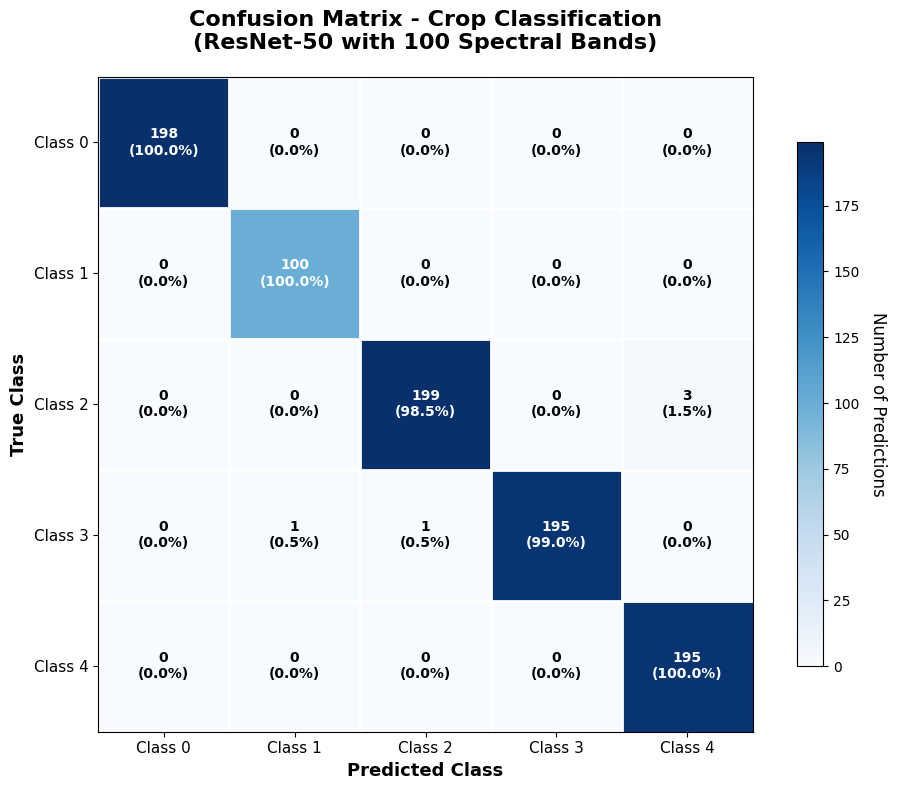

DETAILED CLASSIFICATION REPORT
Total Test Samples: 892
Correct Predictions: 887
Incorrect Predictions: 5


In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create beautiful confusion matrix visualization
plt.figure(figsize=(10, 8))

# Create the heatmap
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Number of Predictions', rotation=270, labelpad=20, fontsize=12)

# Set title
plt.title('Confusion Matrix - Crop Classification\n(ResNet-50 with 100 Spectral Bands)', 
          fontsize=16, fontweight='bold', pad=20)

# Set labels
class_names = [f'Class {i}' for i in range(7)]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=11)
plt.yticks(tick_marks, class_names, fontsize=11)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')

# Add text annotations with numbers and percentages
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Calculate percentage
        percentage = cm[i, j] / cm[i, :].sum() * 100 if cm[i, :].sum() > 0 else 0
        
        # Choose text color based on background
        text_color = "white" if cm[i, j] > thresh else "black"
        
        # Add count and percentage
        plt.text(j, i, f'{cm[i, j]}\n({percentage:.1f}%)',
                ha="center", va="center", 
                color=text_color, fontsize=10, fontweight='bold')

# Add grid lines for better separation
for i in range(len(class_names)):
    plt.axhline(i-0.5, color='white', linewidth=2)
    plt.axvline(i-0.5, color='white', linewidth=2)


plt.tight_layout()
plt.show()

# Print detailed classification report
print("="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(f"Overall Test Accuracy: {accuracy:.2f}%")
print(f"Total Test Samples: {len(true_labels)}")
print(f"Correct Predictions: {np.trace(cm)}")
print(f"Incorrect Predictions: {len(true_labels) - np.trace(cm)}")